In [ ]:
# データのロード
import pandas as pd
import re
import numpy as np
import random
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
from torch import nn
from matplotlib import pyplot as plt

In [ ]:
#データの読み込み
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chapter09/train.txt', sep="\t")
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chapter09/test.txt', sep="\t")
valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chapter09/valid.txt', sep="\t")
# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())


# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)

学習データ
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64
検証データ
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64
評価データ
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64


In [ ]:
#BERTのデータセットを作成
class BERTDataSet(Dataset):

    def __init__(self, X, y, phase):
        self.X = X['TITLE']
        self.y = y
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.phase = phase

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        sentence = self.X[idx]
        sentence = str(sentence)
        sentence = " ".join(sentence.split())

        bert_sens = self.tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, # [CLS],[SEP]
                                max_length = 20,
                                pad_to_max_length = True, # add padding to blank
                                truncation=True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        labels = self.y[idx]

        return {
                'ids': ids,
                'mask': mask,
                'labels': labels,
                }

train_dataset = BERTDataSet(train, Y_train, phase='train')
valid_dataset = BERTDataSet(valid, Y_valid, phase='val')
test_dataset = BERTDataSet(test, Y_test, phase='val')

# 動作確認
train_dataset[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'ids': tensor([  101,  6796, 12170, 22669,  2104,  4812,  2005,  4692, 13742,  2012,
          4913,  1004, 18396,  1005,  1055,   102,     0,     0,     0,     0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
 'labels': tensor(2)}

In [ ]:
# DataLoaderを作成
batch_size = 64

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(1234)

train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
valid_dataloader = DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs = next(batch_iter)
print(inputs['ids'].size())
print(inputs['mask'].size())
print(inputs['labels'].size())

torch.Size([64, 20])
torch.Size([64, 20])
torch.Size([64])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#データローダ―の中身を確認
print(inputs['ids'])
print(inputs['mask'])
print(inputs['labels'])

tensor([[  101,  9606, 12584,  ...,  1012,  1012,   102],
        [  101, 12495, 25832,  ...,     0,     0,     0],
        [  101,  7922, 23021,  ...,     0,     0,     0],
        ...,
        [  101, 24869,  2100,  ...,     0,     0,     0],
        [  101,  8731,  2758,  ...,     0,     0,     0],
        [  101, 10651,  1015,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([2, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1,
        0, 0, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 3, 2, 3, 1, 2, 0, 2,
        0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0])


In [ ]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, hidden_size, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Sequential(
                                nn.Linear(768, hidden_size),
                                nn.ReLU(),
                                nn.BatchNorm1d(hidden_size),
                                nn.Linear(hidden_size, output_size)
                                )

    def forward(self, ids, mask):
        out = self.bert(ids, attention_mask=mask)[-1]
        out = self.fc(self.drop(out))
        return out

In [ ]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(torch.cuda.get_device_name())
    print("使用デバイス:", device)

    # ネットワークをgpuへ
    net.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for data in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおくる
                ids = data['ids'].to(device)
                mask = data['mask'].to(device)
                labels = data['labels'].to(device)
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(ids, mask)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * ids.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
    return train_loss, train_acc, valid_loss, valid_acc


# パラメータの設定
DROP_RATE = 0.2
HIDDEN_SIZE = 256
OUTPUT_SIZE = 4
BATCH_SIZE = 64
NUM_EPOCHS = 8
LEARNING_RATE = 1e-5

# モデルの定義
net = BERTClass(DROP_RATE, HIDDEN_SIZE, OUTPUT_SIZE)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=net.parameters(), lr=LEARNING_RATE)

train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Tesla T4
使用デバイス: cuda:0
Epoch 1 / 8 (train) Loss: 0.6313, Acc: 0.7835, (val) Loss: 0.2644, Acc: 0.9183
Epoch 2 / 8 (train) Loss: 0.2727, Acc: 0.9166, (val) Loss: 0.2126, Acc: 0.9370
Epoch 3 / 8 (train) Loss: 0.1889, Acc: 0.9440, (val) Loss: 0.2025, Acc: 0.9363
Epoch 4 / 8 (train) Loss: 0.1330, Acc: 0.9621, (val) Loss: 0.2035, Acc: 0.9415
Epoch 5 / 8 (train) Loss: 0.0996, Acc: 0.9731, (val) Loss: 0.2056, Acc: 0.9408
Epoch 6 / 8 (train) Loss: 0.0746, Acc: 0.9808, (val) Loss: 0.2131, Acc: 0.9378
Epoch 7 / 8 (train) Loss: 0.0587, Acc: 0.9860, (val) Loss: 0.2141, Acc: 0.9408
Epoch 8 / 8 (train) Loss: 0.0415, Acc: 0.9916, (val) Loss: 0.2219, Acc: 0.9445


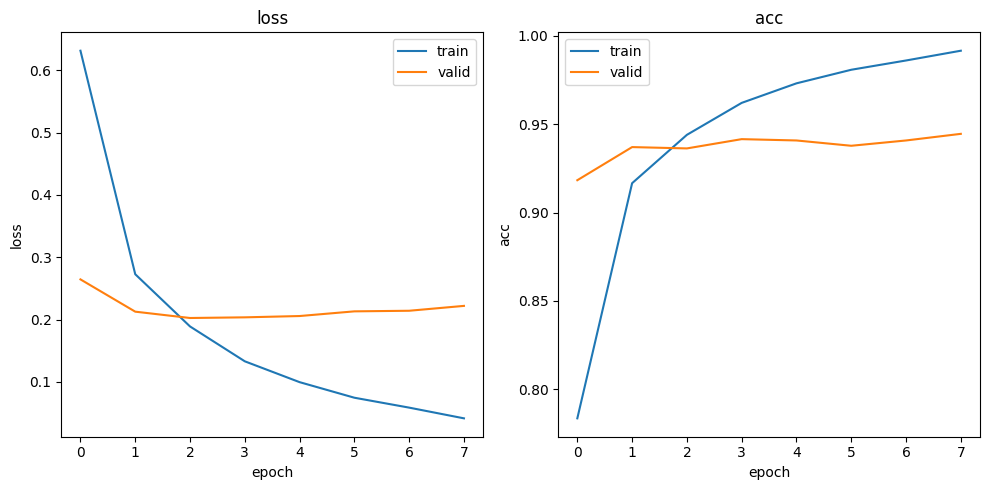

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


学習データの正解率: 0.9958
検証データの正解率: 0.9445
テストデータの正解率: 0.9438


In [ ]:
#精度計算用の関数を定義
def calc_acc(net, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()
    corrects = 0
    with torch.no_grad():
        for data in dataloader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)
            outputs = net(ids, mask)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data).cpu()
    return corrects / len(dataloader.dataset)

#グラフの描画
fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(NUM_EPOCHS)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

#精度の表示
acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install torchinfo